In [78]:
import pandas as pd
import numpy as np
import seaborn as sns

In [79]:
df_de = pd.read_csv('D:\\OneDrive\\Vassar\\DataFest\\data\\DE\\de.csv', parse_dates=['DATE'])
df_ca = pd.read_csv('D:\\OneDrive\\Vassar\\DataFest\\data\\CA\\ca.csv', parse_dates=['DATE'])
df_uk = pd.read_csv('D:\\OneDrive\\Vassar\\DataFest\\data\\UK\\uk.csv', parse_dates=['DATE'])
df_us = pd.read_csv('D:\\OneDrive\\Vassar\\DataFest\\data\\US\\US\\us18.csv', parse_dates=['DATE'])

In [80]:
def get_drug_names(df, country):
    # returns a list of drug names for convenience
    if country == 'de':
        i = 14
    elif country == 'ca':
        i = 16
    elif country == 'uk':
        i = 19
    elif country == 'us':
        i = 17
    
    drugs = [x for x in df.columns if 'NMU' in x][:i]
    drugs = [x.split('_')[0] for x in drugs]

    if country == 'ca':
        drugs.remove('COTC')
    elif country == 'uk':
        drugs.remove('DOTC')

    return drugs

In [81]:
def get_use_cat(df, country):
    # make new df so old dataset is not affected
    new_df = df.copy()
    # get list of drug names
    drugs = get_drug_names(df, country)
    # make categorical variable for each drug
    for drug in drugs:
        new_df[f'{drug}_USE_CAT'] = new_df[f'{drug}_USE'] + new_df[f'{drug}_NMU']
        new_df[f'{drug}_USE_CAT'].fillna(value=0, inplace=True)
    # in the returned df, each drug now has a column indicating how the correspondent uses the drug
    # 0 -> never used
    # 1 -> used for prescription purposes
    # 2 -> used for recreational purposes
    return new_df

In [82]:
def calculate_proportions(df, country):
    new_df = get_use_cat(df)
    drugs = get_drug_names(df, country)
    # empty dict to insert values
    d = {}
    # for each drug, get proportions of recreational use
    for drug in drugs:
        # get number of people for prescription and recreational purposes
        num_pre = new_df[f'{drug}_USE_CAT'].value_counts().loc[1.0]
        num_rec = new_df[f'{drug}_USE_CAT'].value_counts().loc[2.0]
        # get percentage of recreational usage
        percentage = num_rec / (num_pre + num_rec)
        # insert into dictionary
        d[drug] = percentage
    return d

In [83]:
def get_pres_predictors(df, country):
    # returns a df with columns containing prescripted drug use category
    df_use = get_use_cat(df, country)
    drugs = get_drug_names(df, country)
    pred_cols = [x+'_USE_CAT' for x in drugs]
    return df_use[pred_cols]

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [85]:
def decision_tree(df, country):
    X_pres = get_pres_predictors(df_de, country)
    y = df['DAST_CAT']
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_pres, y, test_size=0.33, random_state=42)
    # train model
    decision_tree = DecisionTreeClassifier(random_state=42, max_depth=2)
    decision_tree = decision_tree.fit(X_train, y_train)
    # add cross-validation???
    cv_score = cross_val_score(decision_tree, X_train, y_train, cv=10).mean()
    print(f'CV-Score: {round(cv_score*100, 4)}%')
    # check perdformance in test set
    df_prediction = pd.DataFrame()
    df_prediction['Predicted'], df_prediction['Actual'] = decision_tree.predict(X_test), y_test.values
    df_prediction = df_prediction.assign(Correct = df_prediction['Predicted'] == df_prediction['Actual'])
    # calculate accuracy in test set
    acc = df_prediction['Correct'].value_counts()[True] / len(df_prediction)
    print(f'Accuracy: {round(acc*100, 4)}%')

In [86]:
decision_tree(df_de, 'de')

CV-Score: 52.6673%
Accuracy: 53.4931%


# Can you be a junkie... but unintentionally?

In [87]:
def got_pres_for_pain(df):
    # this function returns a list indicating if a person has received prescription for pain
    df_new = df.copy()
    PRES_FOR_PAIN = []
    for i in range(len(df_new)):
        # Have the patient received prescription for chronic or acute pain?
        PAIN_CHRONIC_RX = df_new.at[i, 'PAIN_CHRONIC_RX']
        PAIN_ACUTE_RX = df_new.at[i, 'PAIN_ACUTE_RX']
        PRES_FOR_PAIN.append(pd.notna(PAIN_CHRONIC_RX) or pd.notna(PAIN_ACUTE_RX))
    return PRES_FOR_PAIN

In [88]:
def get_recr_use(df, country):
    # this function returns a list indicating NMU of one or more drugs
    df_new = df.copy()
    drugs = get_drug_names(df_new, country)
    use_cat = [x+'_USE_CAT' for x in drugs]
    RECR_USE = []
    # loop thru df,
    # if at least one drug has been used for recreational purposes, mark True
    for i in range(len(df)):
        recr_use = False
        for drug in use_cat:
            if df_new.at[i, drug] == 2.0:
                recr_use = True
                break
        RECR_USE.append(recr_use)
    return RECR_USE

In [89]:
def filter_nmu(df, country):
    # this function filters out the people who:
    #   - suffers from chronic or acute pain
    #   - have sought professional help
    #   - have received prescription
    #   - is using one or more prescriptive drug for recreation
    df_new = get_use_cat(df, country)
    # has this person received prescription for pain?
    df_new['PRES_FOR_PAIN'] = got_pres_for_pain(df_new)
    # is this person using the drug for recreational purposes?
    df_new['RECR_USE'] = get_recr_use(df_new, country)
    # drop irrelevant observations
    df_new = df_new.query("PRES_FOR_PAIN==True and RECR_USE==True")
    return df_new

## How old are the people who got addicted to prescription drugs?

Text(0.5, 1.0, 'GERMANY')

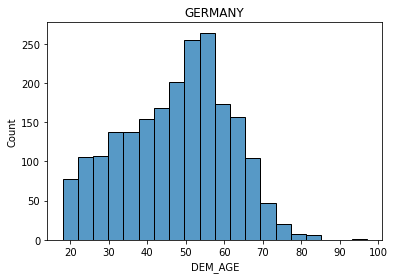

In [90]:
df_nmu_de = filter_nmu(df_de, 'de')
sns.histplot(df_nmu_de, x='DEM_AGE', bins=20).set_title('GERMANY')

Text(0.5, 1.0, 'CANADA')

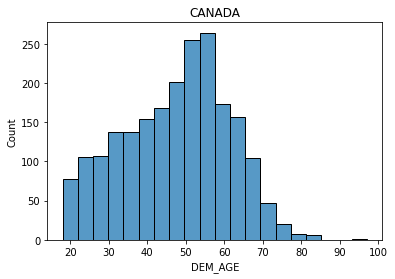

In [91]:
df_nmu_ca = filter_nmu(df_ca, 'ca')
sns.histplot(df_nmu_de, x='DEM_AGE', bins=20).set_title('CANADA')

Text(0.5, 1.0, 'UK')

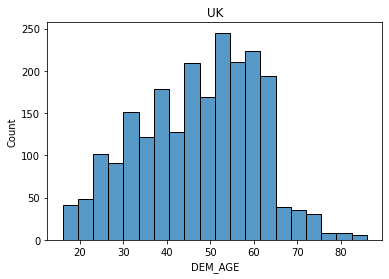

In [92]:
df_nmu_uk = filter_nmu(df_uk, 'uk')
sns.histplot(df_nmu_uk, x='DEM_AGE', bins=20).set_title('UK')

Text(0.5, 1.0, 'US')

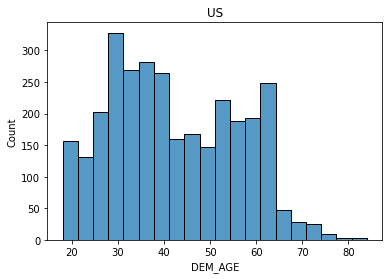

In [93]:
df_nmu_us = filter_nmu(df_us, 'us')
sns.histplot(df_nmu_us, x='DEM_AGE', bins=20).set_title('US')